In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
print(tf.__version__)
print(tfio.__version__)

2.13.0
0.33.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CAPUCHIN_FILE = r"/content/drive/MyDrive/Bird Clippings/Parsed_Capuchinbird_Clips/XC114131-0.wav"
NOT_CAPUCHIN_FILE = r"/content/drive/MyDrive/Bird Clippings/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav"

In [ ]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    #load encoded wav file
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    #removes trailing axis
    wav = tf.squeeze(wav, axis=-1)

    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    #goes from 44100Hz to 16000Hz
    if sample_rate != 16000:
        wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

In [ ]:
wave

<tf.Tensor: shape=(40000,), dtype=float32, numpy=
array([-2.1452930e-08,  2.9903514e-08,  2.3691292e-08, ...,
        1.1810826e-02,  1.3428938e-02,  3.8246573e-03], dtype=float32)>

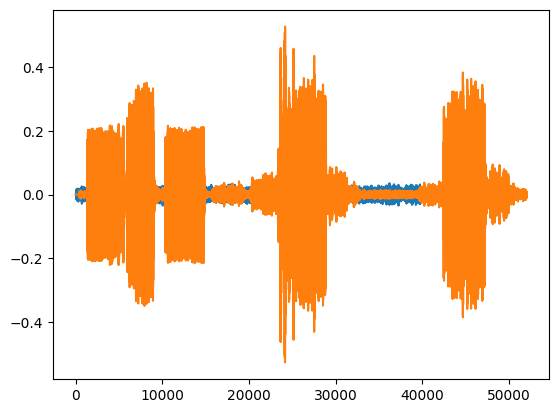

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
#DEFINE PATHS TO POSITIVE AND NEGATIVE DATA
POS = '/content/drive/MyDrive/Bird Clippings/Parsed_Capuchinbird_Clips'
NEG = '/content/drive/MyDrive/Bird Clippings/Parsed_Not_Capuchinbird_Clips'

In [ ]:
#CREATING TENSORFLOW DATASETS
pos = tf.data.Dataset.list_files(POS + '/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')
pos.as_numpy_iterator().next()

b'/content/drive/MyDrive/Bird Clippings/Parsed_Capuchinbird_Clips/XC46241-4.wav'

In [ ]:
#ADD LABELS AND COMBINE POSITIVE AND NEGATIVE SAMPLES
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)
data.shuffle(10000).as_numpy_iterator().next()

(b'/content/drive/MyDrive/Bird Clippings/Parsed_Not_Capuchinbird_Clips/crickets-sound-effect-11.wav',
 0.0)

In [ ]:
#DETERMINING AVERAGE LENGTH OF A CAPUCHIN CALL

#CALCULATING WAVE CYCLE LENGTH
lengths = []
#os.listdir(os.path.join('content', 'Parsed_Capuchinbird_Clips'))
for file in os.listdir('/content/drive/MyDrive/Bird Clippings/Parsed_Capuchinbird_Clips'):
    tensor_wave = load_wav_16k_mono(os.path.join('/content/drive/MyDrive/Bird Clippings/Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [ ]:
#CALCULATING MEAN, MIN AND MAX
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [ ]:
#CONVERTING DATA INTO A SPECTOGRAM

def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype = tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    #basically for the aves less than 48000, it wont fit the 48000 mark,
    #so we add that many no of zeros witht the help of zero_padding so that
    #it reaches the 48000 mark and we can work on the data properly
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    return spectogram, label

In [ ]:
#TESTING OUT THE FUNCTION AND VIZ THE SPECTOGRAM

filepath, label = positives.shuffle(buffer_size = 10000).as_numpy_iterator().next()
spectogram, label = preprocess(filepath, label)

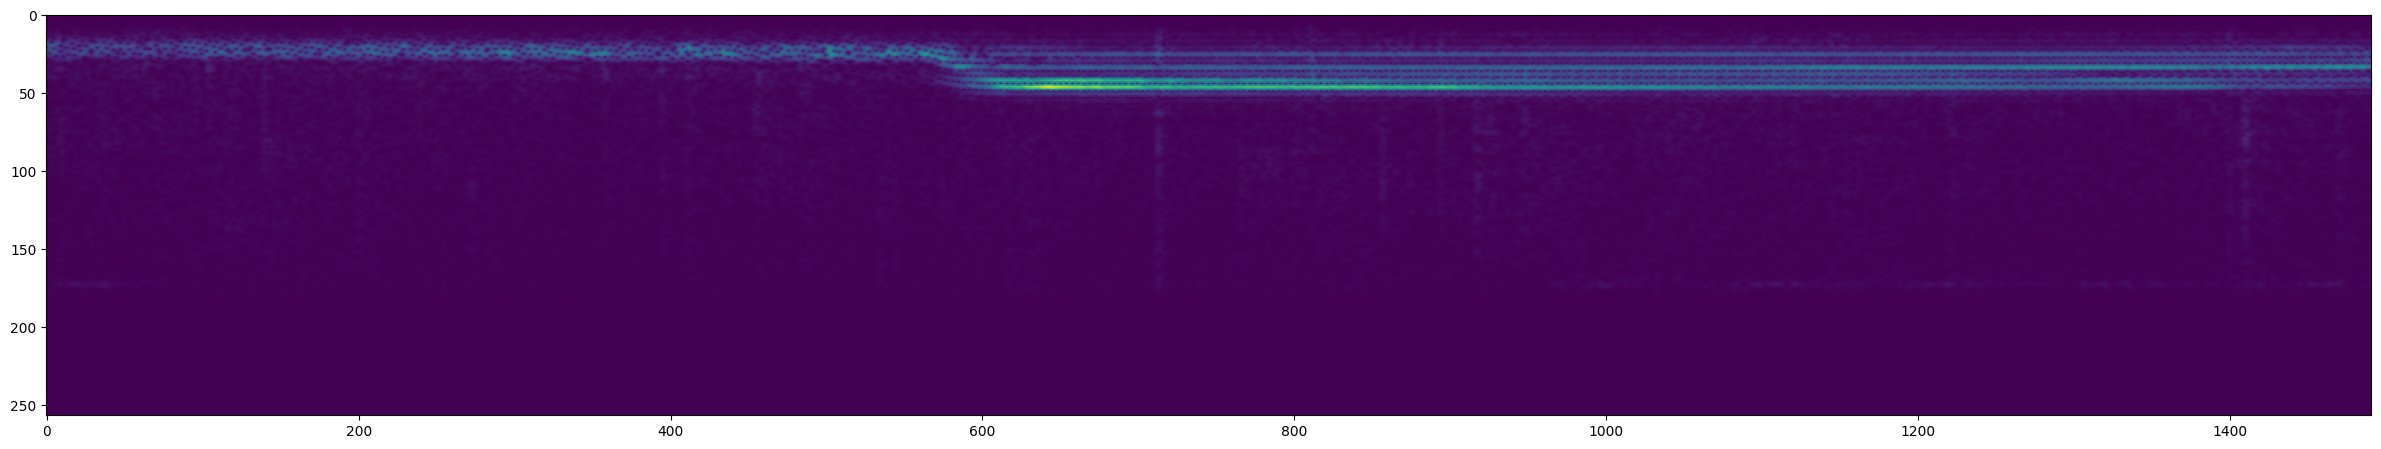

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

In [ ]:
#CREATING TRAINING AND TESTING PARTITIONS
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [ ]:
#SPLITTING INTO TRAINING AND TEST PARTITIONS
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
#TEST ONE BATCH
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [ ]:
labels

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
#BUILDING DEEP LEARNING MODEL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape = (1491, 257,1)),
    Flatten(),
    Dense(units = 48, activation = 'relu'),
    Dense(units = 1, activation = 'sigmoid')
])

model.compile('Adam', loss = 'BinaryCrossentropy', metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 flatten (Flatten)           (None, 6075120)           0         
                                                                 
 dense (Dense)               (None, 48)                291605808 
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 291606017 (1.09 GB)
Trainable params: 291606017 (1.09 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#FITTING THE MODEL
hist = model.fit(train, epochs = 4, validation_data = test)

Epoch 1/4
36/36 [==============================] - 303s 8s/step - loss: 18.4919 - recall: 0.8963 - precision: 0.7617 - val_loss: 2.0050 - val_recall: 1.0000 - val_precision: 0.9444
Epoch 2/4
36/36 [==============================] - 298s 8s/step - loss: 1.5972 - recall: 0.9869 - precision: 0.9679 - val_loss: 0.4771 - val_recall: 1.0000 - val_precision: 0.9818
Epoch 3/4
36/36 [==============================] - 302s 8s/step - loss: 0.2258 - recall: 0.9935 - precision: 0.9809 - val_loss: 0.0026 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 326s 9s/step - loss: 0.0285 - recall: 0.9937 - precision: 1.0000 - val_loss: 0.1535 - val_recall: 1.0000 - val_precision: 0.9600


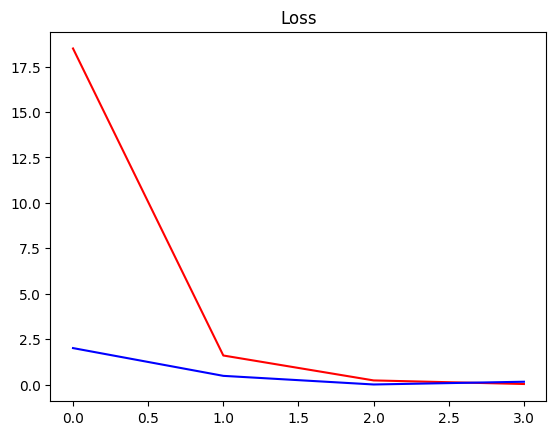

In [ ]:
#PLOTTING OUR LOSS
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

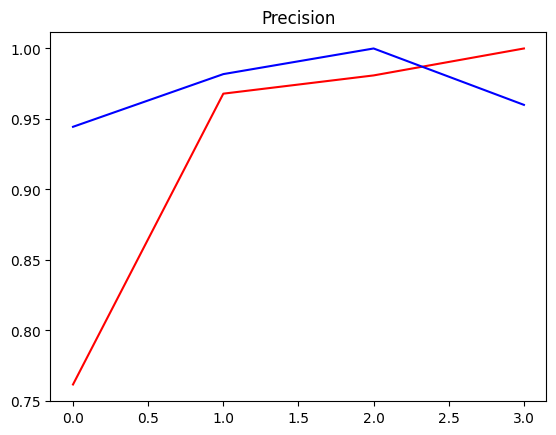

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

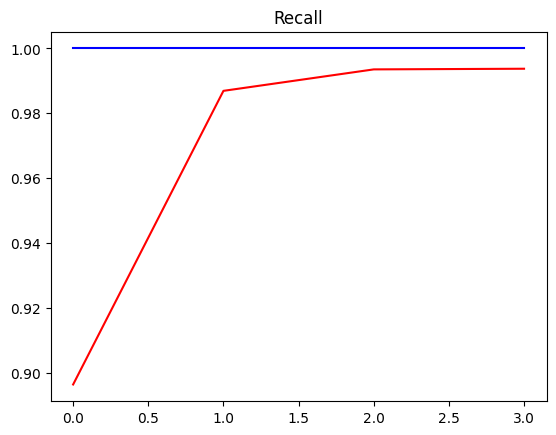

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
#Making a Prediction on a Single Clip
x_test, y_test = test.as_numpy_iterator().next()
x_test.shape

(16, 1491, 257, 1)

In [ ]:
y_test.shape

(16,)

In [ ]:
yhat = model.predict(x_test)
yhat

1/1 [==============================] - 1s 1s/step


array([[3.05654651e-17],
       [1.00000000e+00],
       [0.00000000e+00],
       [7.57134977e-09],
       [1.00000000e+00],
       [4.13209634e-23],
       [6.18408302e-09],
       [0.00000000e+00],
       [1.41946385e-18],
       [0.00000000e+00],
       [1.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.21069685e-01]], dtype=float32)

In [ ]:
#CONVERTING LOGITS TO CLASSES
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [ ]:
y_test.astype(int)

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [ ]:
#BUILDING FOREST PARSING FUNCTIONS
def load_mp3_16k_mono(filename):
  res = tfio.audio.AudioIOTensor(filename)
  #convert to tensor and combine channels
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis=1) / 2
  # extracting sample rate and cast
  sample_rate = res.rate
  sample_rate = tf .cast(sample_rate, dtype = tf.int64)
  #resampling to 16khz
  wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out = 16000)
  return wav

In [ ]:
mp3 = '/content/drive/MyDrive/Bird Clippings/Forest Recordings/recording_00.mp3'

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
#Converting the big mp3 file into audio slices
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size = 1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()
samples.shape

(1, 48000)

In [ ]:
#BUILDING FUNCTION TO CONVERT CLIPS INTO WINDOWED SPECTOGRAMS
def preprocess_mp3(sample, index):
  sample = sample[0]
  zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
  wav = tf.concat([zero_padding, sample], 0)
  spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectogram = tf.abs(spectogram)
  spectogram = tf.expand_dims(spectogram, axis = 2)
  return spectogram

In [ ]:
#CONVERTING LONGER CLIPS INTO WINDOWS AND MAKE PREDICTIONS
audio_slices  = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size = 1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 9s 9s/step


In [ ]:
#GROUPING CONSECUTIVE DETECTIONS
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
calls = tf.math.reduce_sum(yhat)
calls

<tf.Tensor: shape=(), dtype=int32, numpy=13>

In [ ]:
#MAKING PREDICTIONS

#LOOPING THROUGH ALL RECORDINGS AND MAKING PREDICTIONS
results = {}
for file in os.listdir('/content/drive/MyDrive/Bird Clippings/Forest Recordings'):
  FILEPATH = os.path.join('/content/drive/MyDrive/Bird Clippings/Forest Recordings', file)
  wav = load_mp3_16k_mono(FILEPATH)
  audio_slices  = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size = 1)
  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(64)

  yhat = model.predict(audio_slices)
  results[file] = yhat

1/1 [==============================] - 7s 7s/step


In [ ]:
#CONVERT PREDICTIONS INTO CLASSES
class_preds = {}
for file, logits in results.items():
  class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]


In [ ]:
#GROUPING CONSECUTIVE DETECTIONS
postprocessed = {}
for file, scores in class_preds.items():
  postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_02.mp3': 0,
 'recording_04.mp3': 6,
 'recording_05.mp3': 0,
 'recording_03.mp3': 0,
 'recording_01.mp3': 0,
 'recording_00.mp3': 13,
 'recording_14.mp3': 0,
 'recording_09.mp3': 0,
 'recording_17.mp3': 5,
 'recording_08.mp3': 17,
 'recording_06.mp3': 7,
 'recording_19.mp3': 4,
 'recording_12.mp3': 9,
 'recording_15.mp3': 2,
 'recording_07.mp3': 2,
 'recording_16.mp3': 4,
 'recording_18.mp3': 14,
 'recording_13.mp3': 0,
 'recording_11.mp3': 6,
 'recording_10.mp3': 5,
 'recording_23.mp3': 5,
 'recording_22.mp3': 2,
 'recording_21.mp3': 1,
 'recording_26.mp3': 2,
 'recording_30.mp3': 3,
 'recording_31.mp3': 5,
 'recording_20.mp3': 0,
 'recording_24.mp3': 0,
 'recording_29.mp3': 0,
 'recording_27.mp3': 0,
 'recording_32.mp3': 2,
 'recording_25.mp3': 2,
 'recording_28.mp3': 4,
 'recording_35.mp3': 0,
 'recording_40.mp3': 5,
 'recording_33.mp3': 0,
 'recording_46.mp3': 3,
 'recording_38.mp3': 2,
 'recording_45.mp3': 7,
 'recording_42.mp3': 0,
 'recording_41.mp3': 0,
 'recording_3

In [ ]:
#EXPORTING RESULTS AS A CSV
import csv
with open('capuchinbird_results.csv', 'w', newline='') as f:
  writer = csv.writer(f, delimiter = ',')
  writer.writerow(['recording', 'capuchin_calls'])
  for key, value in postprocessed.items():
    writer.writerow([key, value])